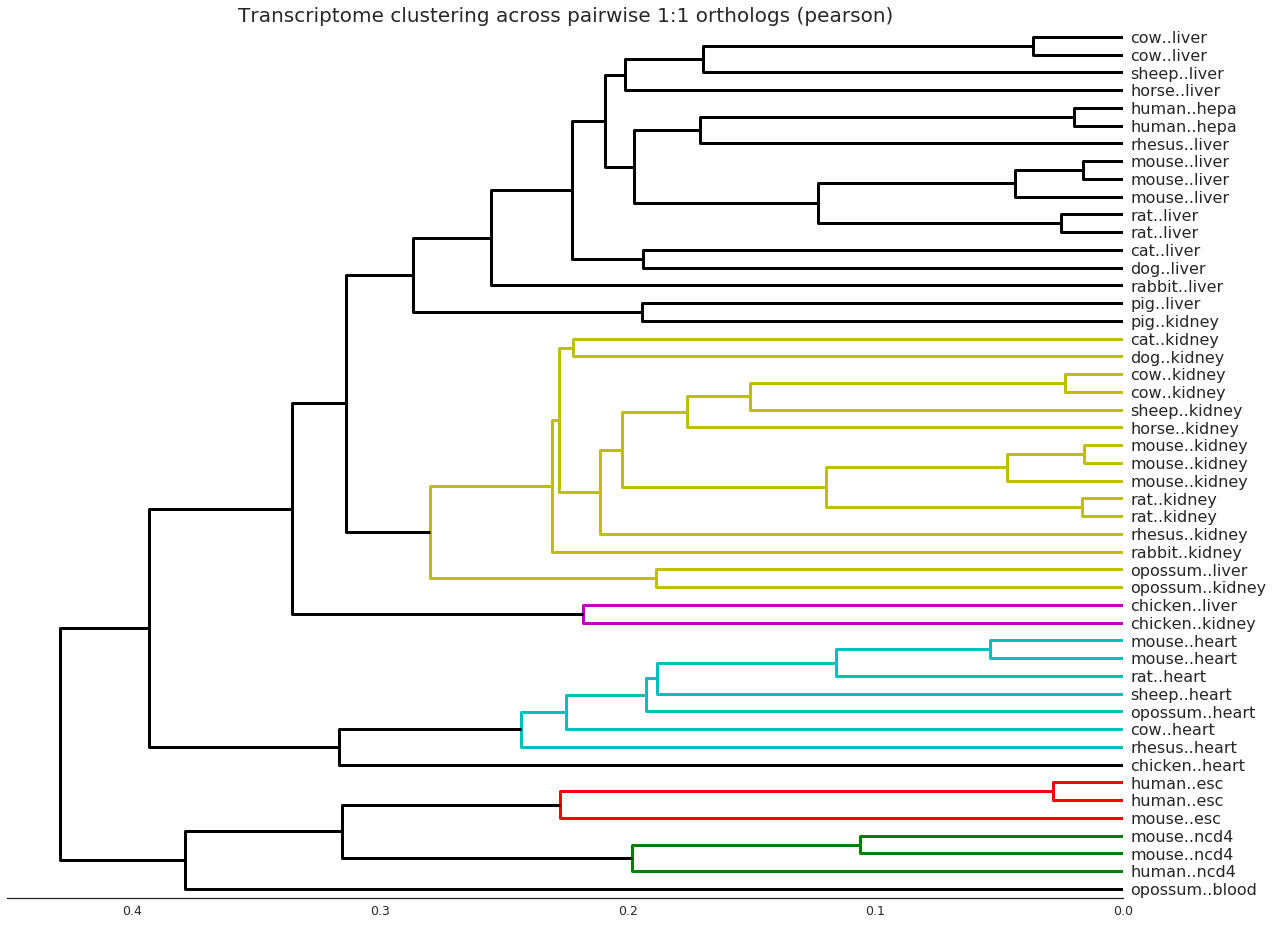

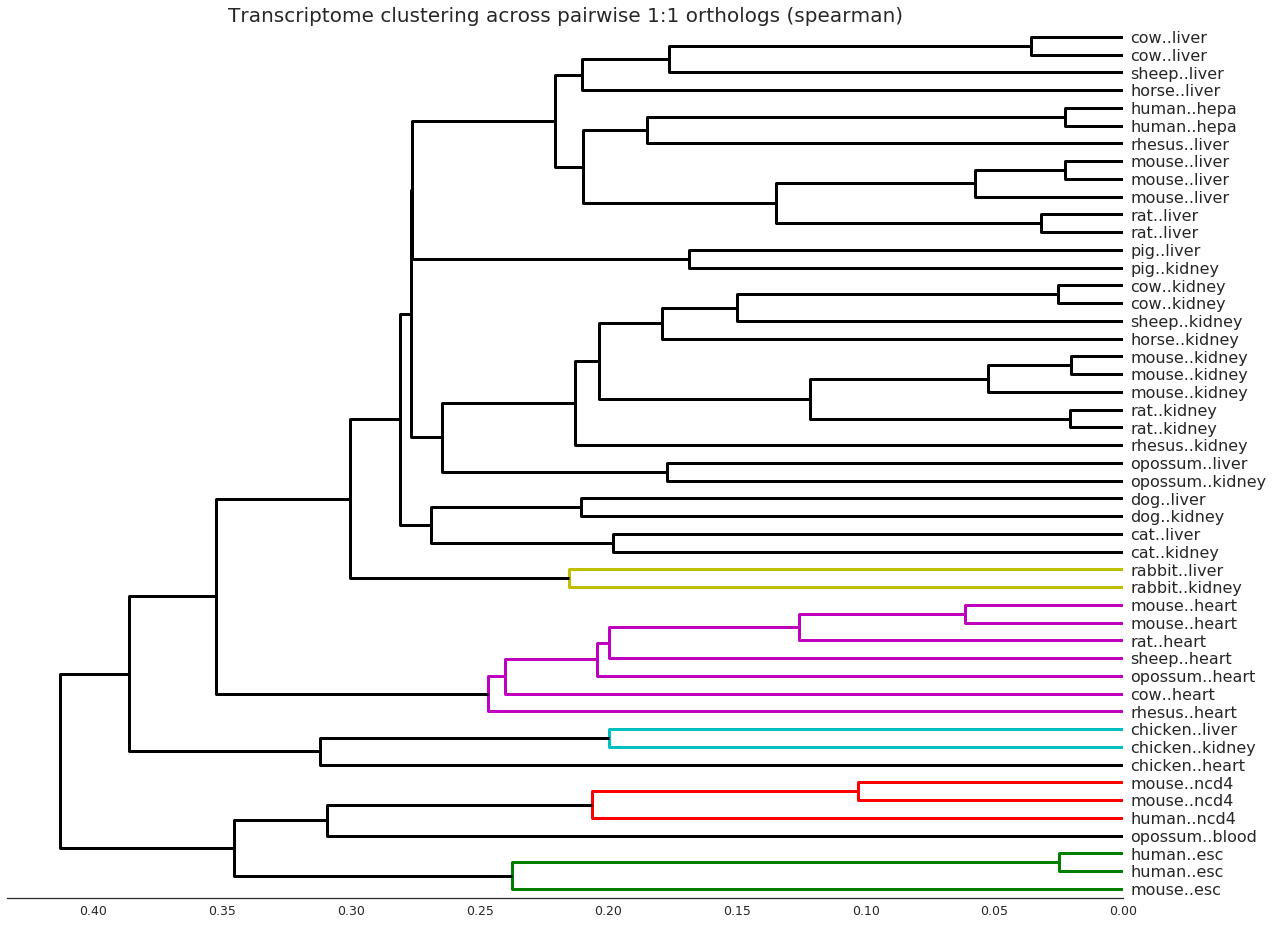

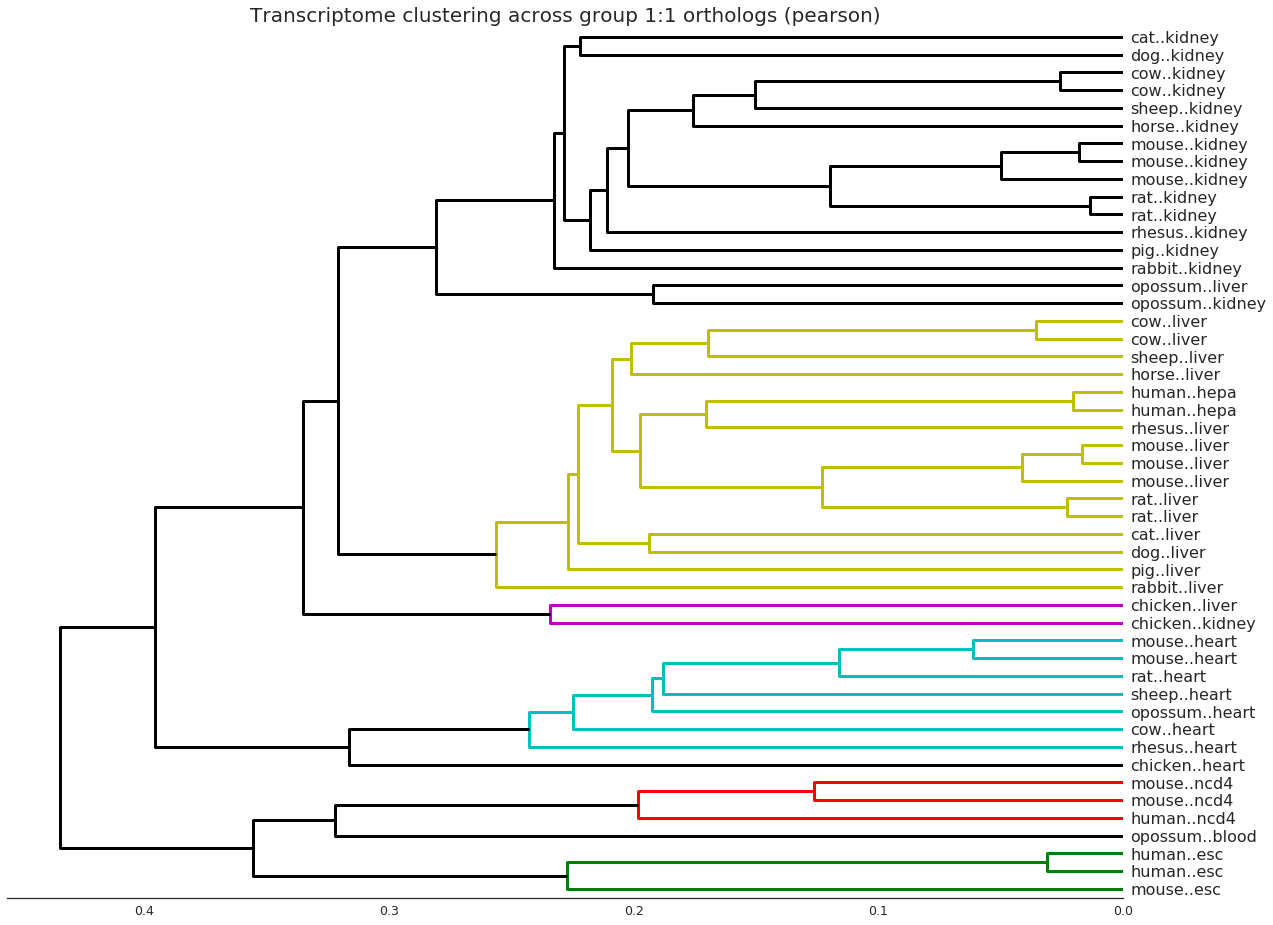

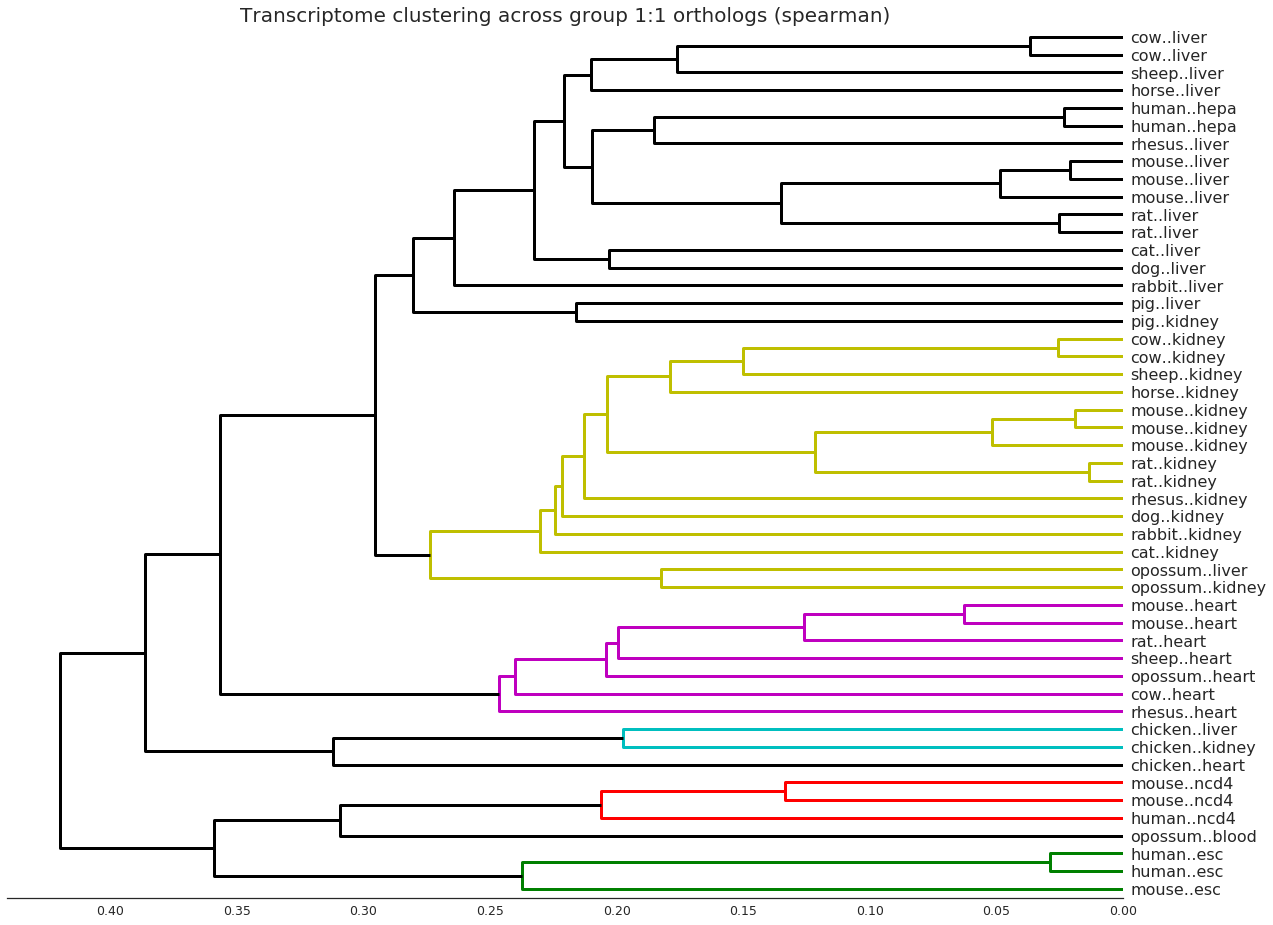

run_ortho_clust executed


In [82]:
%matplotlib inline

import os as os
import numpy as np
import operator as op
import json as js
import pandas as pd
import scipy.cluster.hierarchy as hc
import scipy.spatial.distance as dst
from scipy.stats import pearsonr, spearmanr
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

sns.set(style='white',
        font_scale=1.25,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

fhgfs_base = '/TL/deep/fhgfs/projects/pebert/thesis'
ref_folder = os.path.join(fhgfs_base, 'refdata/orthologs/hdf')
data_folder = os.path.join(fhgfs_base, 'projects/cross_species/rawdata/conv/agg')

cache_folder = '/home/pebert/.jupyter/cache'

conf_folder = '/home/pebert/work/code/mpggit/crossspecies/graphics'

plot_labels = js.load(open(os.path.join(conf_folder, 'labels', 'cs_labels.json'), 'r'))
plot_colors = js.load(open(os.path.join(conf_folder, 'colors', 'cs_colors.json'), 'r'))
plot_shapes = js.load(open(os.path.join(conf_folder, 'shapes', 'cs_shapes.json'), 'r'))

exec_ortho_clust = True

show_figures = True

out_folder = '/TL/deep-external01/nobackup/pebert/cloudshare/mpiinf/phd/chapter_projects/crossspecies/figures/pub'
save_figures = True

def run_ortho_clust():
    if not exec_ortho_clust:
        return False
    ignore_samples = ['MEL', 'K562', 'GM12878', 'CH12', 'brain']
    cache_file = os.path.join(cache_folder, 'plot_ortho_clust.h5')
    if not os.path.isfile(cache_file):
        pw_matrix, grp_matrix = preprocess_data(ignore_samples)
        with pd.HDFStore(cache_file, 'w', complevel=9) as hdf:
            hdf.put('pairwise/pearson', pw_matrix[0], format='table')
            hdf.put('pairwise/spearman', pw_matrix[1], format='table')
            hdf.put('group/pearson', grp_matrix[0], format='table')
            hdf.put('group/spearman', grp_matrix[1], format='table')
    else:
        with pd.HDFStore(cache_file, 'r') as hdf:
            pw_matrix = [hdf['pairwise/pearson'], hdf['pairwise/spearman']]
            grp_matrix = [hdf['group/pearson'], hdf['group/spearman']]
    for ortho_type, mat in zip(['pairwise', 'group'], [pw_matrix, grp_matrix]):
        for meth, data in zip(['pearson', 'spearman'], mat):
            dist_data = dst.squareform(1 - data.values)
            link = hc.linkage(dist_data, method='average', metric='euclidean')
            short_labels = list(map(adjust_label, data.columns))
            fig_title = 'Transcriptome clustering across {} 1:1 orthologs ({})'.format(ortho_type, meth)
            fig = create_dendemann(link, short_labels, fig_title)
            if save_figures:
                outpath = os.path.join(out_folder, 'supp', 'fig_X_supp_hclust_{}_{}.svg'.format(ortho_type, meth))
                fig.savefig(outpath, bbox_inches='tight')
                outpath = outpath.replace('.svg', '.png')
                fig.savefig(outpath, bbox_inches='tight', dpi=300)
    return True
    

def create_dendemann(linkage, labels, title):
    """
    """
    with plt.rc_context({'lines.linewidth': 3}):
        fig, ax = plt.subplots(figsize=(20, 16))
        dend = hc.dendrogram(linkage, labels=labels, orientation='left',
                             leaf_font_size=16,
                             above_threshold_color='black',
                             distance_sort='ascending')
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_title(title, fontsize=20)
    if show_figures:
        plt.show()
    return fig
    
    
def adjust_label(label):
    assm, tissue, _ = label.split('_')
    spec = plot_colors['mapping'][assm]['species']
    if tissue in ['H1hESC', 'ESE14']:
        tissue = 'esc'
    return '{}..{}'.format(spec, tissue)    
    

def preprocess_data(ignore_samples):
    """
    """
    exp_files = os.listdir(data_folder)    
    ortho_file = os.path.join(ref_folder, 'odb9_gene-orthologs.h5')

    done = set()
    pw_corr = {'spearman': set(), 'pearson': set()}
    grp_corr = {'spearman': set(), 'pearson': set()}
    with pd.HDFStore(ortho_file, 'r') as orth:
        grp_ortho = orth['auto/groups']
        for a in exp_files:
            for b in exp_files:
                if (a, b) in done or a == b:
                    continue
                done.add((a, b))
                done.add((b, a))
                file_a = os.path.join(data_folder, a)
                file_b = os.path.join(data_folder, b)
                assm_a = a.split('_')[0]
                assm_b = b.split('_')[0]
                spec_a = plot_colors['mapping'][assm_a]['species']
                spec_b = plot_colors['mapping'][assm_b]['species']
                pw_ortho = orth['auto/pairs/{}/{}'.format(spec_a, spec_b)]
                pw_key = 'og_id_{}_{}'.format(spec_a, spec_b)
                if pw_key not in pw_ortho:
                    pw_key = 'og_id_{}_{}'.format(spec_b, spec_a)
                    if pw_key not in pw_ortho:
                        raise ValueError(pw_key)
                with pd.HDFStore(file_a, 'r') as hdf_a:
                    with pd.HDFStore(file_b, 'r') as hdf_b:
                        tmp = hdf_a['norm/tpm']
                        tmp = pd.DataFrame(np.log1p(tmp.values),
                                           index=tmp.index,
                                           columns=tmp.columns)
                        drop_cols = [c for c in tmp.columns if any([s in c for s in ignore_samples])]
                        data_a = tmp.drop(drop_cols, axis=1, inplace=False)
                        
                        tmp = hdf_b['norm/tpm']
                        tmp = pd.DataFrame(np.log1p(tmp.values),
                                              index=tmp.index,
                                              columns=tmp.columns)
                        drop_cols = [c for c in tmp.columns if any([s in c for s in ignore_samples])]
                        data_b = tmp.drop(drop_cols, axis=1, inplace=False)
                        
                        for m in ['spearman', 'pearson']:
                            self_a = data_a.corr(method=m).round(5).to_dict()
                            for col, row_vals in self_a.items():
                                for row, val in row_vals.items():
                                    pw_corr[m].add((col, row, val))

                            self_b = data_b.corr(method=m).round(5).to_dict()
                            for col, row_vals in self_b.items():
                                for row, val in row_vals.items():
                                    pw_corr[m].add((col, row, val))
                        
                        is_pw = True
                        for ortho, corrs in zip([pw_ortho, grp_ortho], [pw_corr, grp_corr]):
                            sub_a = data_a.loc[data_a.index.isin(pw_ortho['{}_name'.format(spec_a)]), :].copy()
                            assert not sub_a.empty, 'A empty {} - {}'.format(spec_a, spec_b)
                            sub_a['og_id'] = pd.Series(pw_ortho[pw_key].values,
                                                       index=pw_ortho['{}_name'.format(spec_a)])
                            
                            sub_b = data_b.loc[data_b.index.isin(pw_ortho['{}_name'.format(spec_b)]), :].copy()
                            assert not sub_b.empty, 'B empty {} - {}'.format(spec_a, spec_b)
                            sub_b['og_id'] = pd.Series(pw_ortho[pw_key].values,
                                                       index=pw_ortho['{}_name'.format(spec_b)])
                                                        
                            joined = sub_a.merge(sub_b, on='og_id', how='inner')
                            assert not joined.empty, 'Join empty {} - {}'.format(spec_a, spec_b)
                            joined.drop(['og_id'], axis=1, inplace=True)
                                                        
                            for m in ['spearman', 'pearson']:
                                cross = joined.corr(method=m).round(5).to_dict()
                                for col, row_vals in cross.items():
                                    for row, val in row_vals.items():
                                        # avoid recording self-correlation
                                        # for pairwise comparison - not well-defined
                                        if is_pw:
                                            if (assm_a in col and assm_a in row) or (assm_b in col and assm_b in row):
                                                continue
                                        corrs[m].add((col, row, val))
                            is_pw = False
    pw_res = []
    for m in ['pearson', 'spearman']:
        data = pw_corr[m]
        samples = sorted(set([t[0] for t in data]), key=lambda x: tuple(x.split('_')[1:3]))
        extract = op.itemgetter(*(1, 2, 0))
        labels = ['_'.join(extract(s.split('_'))) for s in samples]
        corr_mat = pd.DataFrame(np.zeros((len(samples), len(samples)), dtype=np.float32),
                                index=samples, columns=samples)
        for t in data:
            corr_mat.at[t[0], t[1]] = t[2]
            corr_mat.at[t[1], t[0]] = t[2]
        corr_mat.index = labels
        corr_mat.columns = labels
        pw_res.append(corr_mat)
        
    grp_res = []
    for m in ['pearson', 'spearman']:
        data = grp_corr[m]
        samples = sorted(set([t[0] for t in data]), key=lambda x: tuple(x.split('_')[1:3]))
        extract = op.itemgetter(*(1, 2, 0))
        labels = ['_'.join(extract(s.split('_'))) for s in samples]
        corr_mat = pd.DataFrame(np.zeros((len(samples), len(samples)), dtype=np.float32),
                                index=samples, columns=samples)
        for t in data:
            corr_mat.at[t[0], t[1]] = t[2]
            corr_mat.at[t[1], t[0]] = t[2]
        corr_mat.index = labels
        corr_mat.columns = labels
        grp_res.append(corr_mat)

    return pw_res, grp_res


def make_rgb_tint(color):
    """
    """
    r, g, b = color
    new_r = r + (1 - r) * 0.5
    new_g = g + (1 - g) * 0.5
    new_b = b + (1 - b) * 0.5
    return (new_r, new_g, new_b)
            
execd = run_ortho_clust()
if execd:
    print('run_ortho_clust executed')